<div class="title">Linear Models for Classification</div>
<div class="subtitle">Machine Learning</div>
<div class="author">Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---

**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [2]:
# Standard packages.
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sys

# Custom packages.
from ml import (
	fun_cross_entropy,
	generate_dataset_lbc,
	generate_dataset_lbc_asym,
	grad_cross_entropy,
	plot_dataset_clas,
	plot_linear_model_clas,
)

# Initialisations.
matplotlib.rc("figure", figsize=(15, 5))
seed = 123
sys.dont_write_bytecode = True

# Binary Linear Classification

## First Example

### Dataset

This code generates and plots the dataset.
The underlying (real) model behind the data is linear, in the sense that the best separation is provided by a linear border.

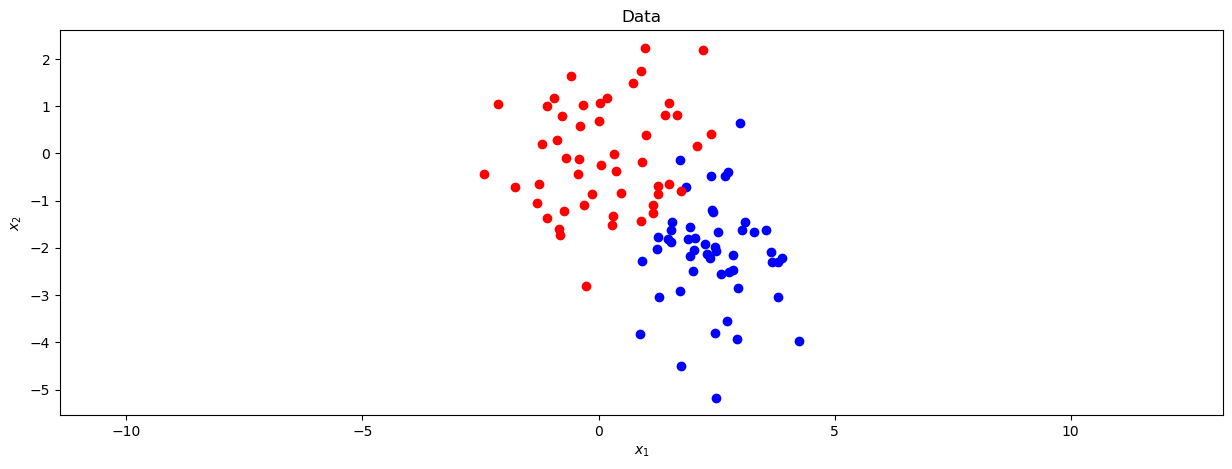

In [3]:
x, y = generate_dataset_lbc(seed, sep=3)
plot_dataset_clas(x, y)

<div class="qst">

* Can this linearity be distinguished also in the plot?
* Can this problem be solved linearly?
* What is the influence of the `sep` parameter?

</div>

Hay dos entradas: x e y. El problema de clasificación y se puede resolver con un clasificador lineal (una recta), aunque no seamos capaces de tener error 0. sep permite cambiar la separación de los clusters. Cuanto mayor sea, más separados están los dos grupos.

### Estimation

A first linear model can be fitted by hand.

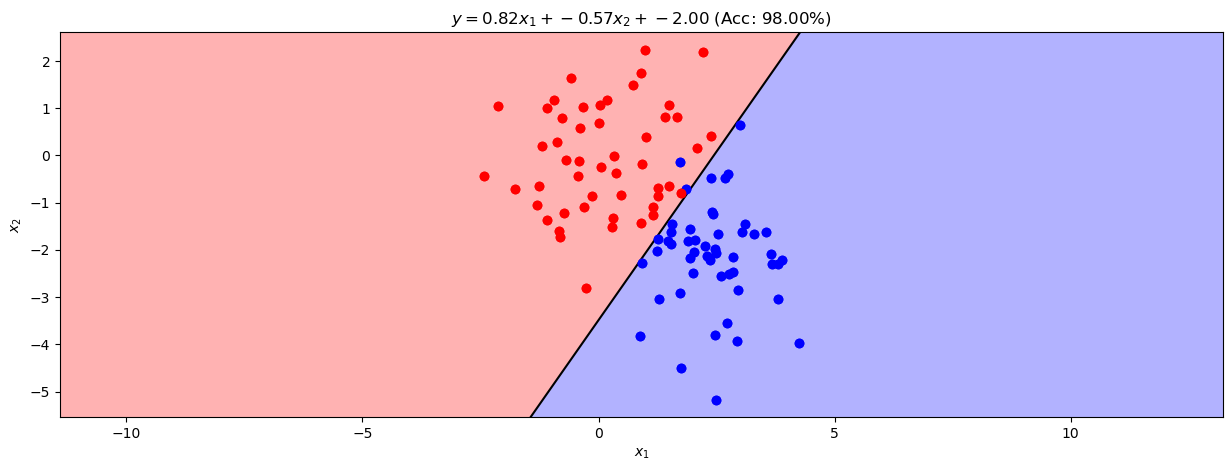

In [37]:
################################################################################
# The parameters of the linear model can be modified here.
# For simplicity, the model is defined by the angle (in degrees) and the intercept.
deg = 125
b = -2
################################################################################

angle = deg / 360.0 * 2 * np.pi
plot_linear_model_clas(x, y, [np.sin(angle), np.cos(angle)], b)

<div class="qst">

* What is the best accuracy (it is shown on top of the plot) that can be obtained?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998381)
</div>

En un modelo lineal de 2 dimensiones, se tendrían que ajustar tres parámetros: b, w1 y w2. En este caso, se ajustan solo 2 parámetros: b y el grado. Se puede multiplicar b, w1 y w2 y el resultado sería lo mismo (valor positivo o negativo).

## Quality of the Model

The following cells change the parameters of the model over a grid and compare the resulting models using the accuracy.

In [35]:
x, y = generate_dataset_lbc(seed)

n_points = 31
deg_vec = np.linspace(0, 360, n_points)
ang_vec = deg_vec / 360.0 * 2 * np.pi
b_vec = np.linspace(-2, 2, n_points)

deg_mat, b_mat = np.meshgrid(deg_vec, b_vec, indexing="ij")
accs = np.zeros(deg_mat.shape)

for i_ang, ang in enumerate(ang_vec):
    for i_b, b in enumerate(b_vec):
        y_p = np.sign(x @ np.array([np.sin(ang), np.cos(ang)]) + b)
        accs[i_ang, i_b] = accuracy_score(y, y_p)

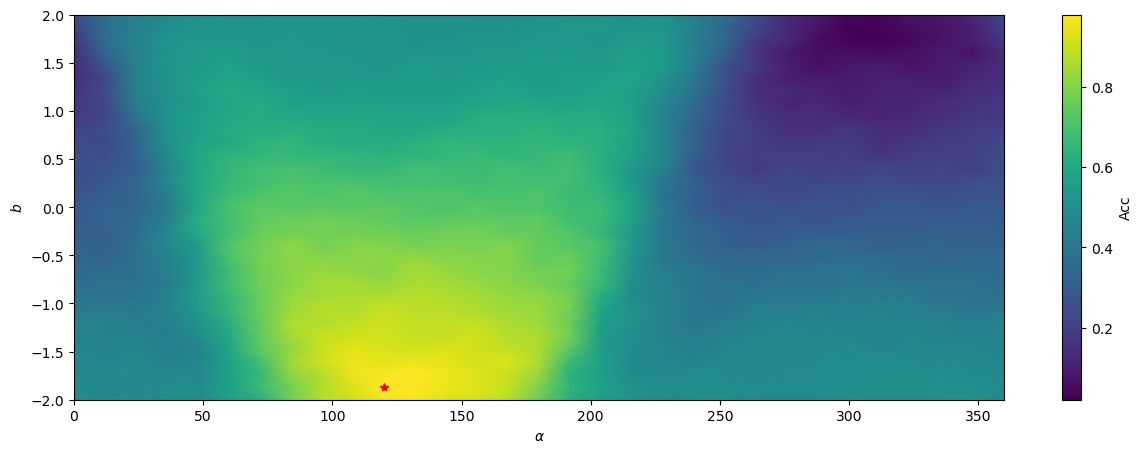

Maximum Acc:	  0.98
Optimal degree:	120.00
Optimal b:	 -1.87


In [36]:
label = "Acc"
ind = np.unravel_index(np.argmax(accs), accs.shape)
plt.pcolormesh(deg_mat, b_mat, accs, shading="gouraud")

deg_opt = deg_vec[ind[0]]
b_opt = b_vec[ind[1]]

plt.plot(deg_opt, b_opt, "r*")
plt.xlabel("$\\alpha$")
plt.ylabel("$b$")
plt.colorbar().ax.set_ylabel(label)
plt.show()
print("Maximum {}:\t{:6.2f}".format(label, accs.max()))
print("Optimal degree:\t{:6.2f}".format(deg_opt))
print("Optimal b:\t{:6.2f}".format(b_opt))

<div class="qst">

* How many models have been evaluated?
* Is this efficient, or even scalable?

</div>

The following cell shows the dependence of the accuracy with respect to $b$ for the optimal value of the angle.

In [ ]:
ang_opt = ang_vec[ind[0]]

n_points = 1000
b_vec = np.linspace(-5, 5, n_points)

accs = np.zeros(n_points)
for i_b, b in enumerate(b_vec):
    y_p = np.sign(x @ np.array([np.sin(ang_opt), np.cos(ang_opt)]) + b)
    accs[i_b] = accuracy_score(y, y_p)

plt.plot(b_vec, accs, ".")
plt.xlabel("$b$")
plt.ylabel("Acc")
plt.show()

<div class="qst">

* What is the problem of this measure?
* Is it continuous, or there are "jumps"?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998383)
</div>

## Training a Regression Linear Model

### Symmetric Dataset

A first approach to linear classifiers is to train a regression linear model over the labels.

In [ ]:
x, y = generate_dataset_lbc(seed)

################################################################################
model = LinearRegression(fit_intercept=True)
model.fit(x, y)
################################################################################

plot_linear_model_clas(x, y, model.coef_, model.intercept_)

<div class="qst inspect">

* Is this model optimal?

</div>

### Asymmetric Dataset

The problem of this approach can be clearly seen with an asymmetric dataset, where one class extends over a larger region than the other. The cell below generates such a dataset.

In [ ]:
x, y = generate_dataset_lbc_asym(seed)
plot_dataset_clas(x, y)

The following cell trains a linear regression model over the asymmetric dataset.

In [ ]:
################################################################################
model = LinearRegression(fit_intercept=True)
model.fit(x, y)
################################################################################

plot_linear_model_clas(x, y, model.coef_, model.intercept_)

<div class="qst inspect">

* Is this model optimal?
* Can a better linear model be found?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998384)
</div>

## Optimization

### Using Gradient Descent

A simple gradient descent can be used to maximize the likelihood and, hence, find the optimal parameters.

In order to do so, it uses the `grad_cross_entropy` function, defined in the module `ml`.
This function first converts the labels to $\mathcal{Y} = \{0, 1\}$, and then it computes the gradient.

In [ ]:
def logistic_regression(X, y, max_iter=1000, eta=1e-2, evolution=False):
    X_bar = np.column_stack((np.ones(X.shape[0]), X))
    w_bar = np.zeros(X_bar.shape[1])

    if evolution:
        evo = np.zeros(max_iter)
    for i in range(max_iter):
        w_bar = w_bar - eta * grad_cross_entropy(X_bar, y, w_bar)
        if evolution:
            evo[i] = fun_cross_entropy(X_bar, y, w_bar)

    w = w_bar[1:]
    b = w_bar[0]

    if evolution:
        return w, b, evo
    else:
        return w, b

<div class="qst">

* Does the previous implementation match the procedure shown in the slides?

</div>

The cells below estimate the logistic regression models for the previous datasets.

In [ ]:
x, y = generate_dataset_lbc(seed)
w, b, evolution = logistic_regression(x, y, evolution=True)
plot_linear_model_clas(x, y, w, b)

In [ ]:
x, y = generate_dataset_lbc_asym(seed)
w, b = logistic_regression(x, y)
plot_linear_model_clas(x, y, w, b)

<div class="qst">

* Is this approach better than the regression models above?
  Why?

→ [Questionnaire](https://posgrado.uam.es/mod/quiz/view.php?id=998388)
</div>

The evolution of the gradient descent method can also be plotted, to see how this algorithm converges.

In [ ]:
plt.semilogy(evolution)
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.title("Convergence of the Gradient Descent")
plt.show()

### Using *scikit-learn*

A linear logistic regression model can also be trained using *scikit-learn*, in particular creating a model with `LogisticRegression` and training it with the `fit` function.

In [ ]:
x, y = generate_dataset_lbc(seed)
model = LogisticRegression(fit_intercept=True, solver="lbfgs")
model.fit(x, y)
plot_linear_model_clas(x, y, model.coef_[0], model.intercept_)

In [ ]:
x, y = generate_dataset_lbc_asym(seed)
model = LogisticRegression(fit_intercept=True, solver="lbfgs")
model.fit(x, y)
plot_linear_model_clas(x, y, model.coef_[0], model.intercept_)

<div class="qst">

* Are these model equivalent to the ones computed using the `logistic_regression` function?

</div>